In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
from datetime import datetime
from dateutil import tz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker


import pynwb
import nspike_helpers as ns 

mdates.rcParams.update({'date.autoformatter.microsecond': '%H:%M:%S.%f'})

/Users/tjd/conda/envs/pynwb/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# debug settings
limit_num_of_tets = None # To speed up testing. Set to None to load all tets

# Session-specific params
#data_dir = '/opt/data46/FrankData/kkay/Bon/'
data_dir = '/Users/tjd/Data/FrankData/kkay/Bon'
data_source = 'Animal Bond'
anim = 'Bon' 
day = 4

# 'Wall clock' (i.e. actual) date and time of the Nspike time = 0 for this experiment.
# NOTE: this is not the true zero_time, as we don't have easy access to that without digging in lab notebooks.
# TODO: dig in lab notebooks, at least to get the date of recording.
dataset_zero_time = datetime(2006, 1, 1, 12, 0, 0, tzinfo=tz.gettz('US/Pacific'))

# General params/presets
file_create_date = datetime.now(tz.tzlocal())

source = 'NSpike data acquisition system'
eeg_samprate = 1500.0 # Hz

eeg_subdir = "EEG"
epochs_file = "times.mat"
tetinfo_file = "tetinfo.mat"
NSpike_timestamps_per_sec = 10000

In [3]:
print(file_create_date)
print(dataset_zero_time)

2018-10-28 15:08:45.177790-07:00
2006-01-01 12:00:00-08:00


### Parse inputs and create NWBfile

In [4]:
day_str = '%02d' % day

nwb_filename = anim + day_str + '_test.nwb'

# check the input arguments
if not os.path.exists(data_dir):
        print('Error: data_dir %s does not exist' % data_dir)
        exit(-1)

# get filename prefix and file locations
prefix = anim.lower()
eeg_path = os.path.join(data_dir, eeg_subdir)

# Calculate the POSIX timestamp when Nspike clock = 0 (seconds)
NSpike_posixtime_offset = dataset_zero_time.timestamp()

# We'll still store NSpike/Trodes zero time in nwbfile.session_start_time, 
# so that we can recreate the experimental timestamps, even though that
# violates the definition of session_start_time as zero time. We need some
# other way to indicate that the timestamps are POSIX (easy: if they are over
# a trillion, then they're POSIX!)

In [5]:
nwbf = pynwb.NWBFile(data_source,
               'Converted NSpike data from %s' % data_dir,
               anim+day_str,
               session_start_time=dataset_zero_time,
               file_create_date=file_create_date,
               lab='Frank Laboratory',
               experimenter='Mattias Karlsson',
               institution='UCSF',
               experiment_description='Recordings from awake behaving rat',
               session_id=data_dir)

### Animal Behavior

In [6]:
# create position, direction and speed
position_list = []
pos = pynwb.behavior.Position(data_source, position_list, 'Position')

direction_list = []
dir = pynwb.behavior.CompassDirection(data_source, direction_list, 'Head Direction')

speed_list = []
speed = pynwb.behavior.BehavioralTimeSeries(data_source, speed_list, 'Speed')

# NOTE that day_inds is 0 based
time_list = {}
nwb_epoch = {}
pos_files = ns.get_files_by_day(data_dir, prefix, 'pos')
task_files = ns.get_files_by_day(data_dir, prefix, 'task')

In [7]:
mat = ns.loadmat_ff(task_files[day], 'task')
task_struct = mat[day]
# find the pos file for this day and load it

mat = ns.loadmat_ff(pos_files[day], 'pos')
pos_struct = mat[day]

# compile a list of time intervals in an array and create the position, head direction and velocity structures
time_list = []

# Assume field order: (time,x,y,dir,vel)
(time_idx, x_idx, y_idx, dir_idx, vel_idx) = range(5)

In [8]:
for epoch_num, pos_epoch in pos_struct.items():

    # convert times to POSIX time
    timestamps = pos_epoch['data'][:,time_idx] + NSpike_posixtime_offset

    # TODO: create a shared TimeSeries for timestamps, across all behavioral timeseries
    # ?? timestamps_obj = pynwb.TimeSeries(timestamps=timestamps...)

    # collect times of epoch start and end
    time_list.append([timestamps[0], timestamps[-1]])

    m_per_pixel = pos_epoch['cmperpixel'][0,0]/100 # NWB wants meters per pixel

    # we can also create new SpatialSeries for the position, direction and velocity information
    #NOTE: Each new spatial series has to have a unique name.
    pos.create_spatial_series(name='Position d%d e%d' % (day, epoch_num), 
                              source='overhead camera',
                              timestamps = timestamps,
                              data=pos_epoch['data'][:, (x_idx, y_idx)] * m_per_pixel,
                              reference_frame='corner of video frame',
                              #conversion=m_per_pixel,
                              #unit='m'
                              ) # *after* conversion

    dir.create_spatial_series(name='Head Direction d%d e%d'% (day, epoch_num), 
                              source='overhead camera',
                              timestamps=timestamps,
                              data=pos_epoch['data'][:, dir_idx],
                              reference_frame='0=facing top of video frame (?), positive clockwise (?)',
                              #unit='radians'
                              )

    speed.create_timeseries(name='Speed d%d e%d' % (day, epoch_num),
                             source='overhead camera',
                             timestamps=timestamps,
                             data=pos_epoch['data'][:, vel_idx] * m_per_pixel,
                             unit='m/s',
                             #conversion=m_per_pixel,
                             description='smoothed movement speed estimate')
time_list = np.asarray(time_list)
                                
    

In [9]:
# create a Processing module for behavior
behav_mod = nwbf.create_processing_module('Behavior', data_source, 'Behavioral variables')
# add the position, direction and speed data
behav_mod.add_data_interface(pos)
behav_mod.add_data_interface(dir)
behav_mod.add_data_interface(speed)

<BehavioralTimeSeries 'Speed' at 0x4636283344>

### Epochs (Not currently implemented)

In [10]:
# # create a list to store all of the fields in the task structure and 
# # a parallel list to store the created task interval structures
# task_fields = []
# task_intervals = []

# # each day will be defined as a single Epoch in NWB so we go through and get the first and last time from the
# # position data
# day_start = time_list[0,0]
# day_end = time_list[-1,1]

# nwb_epoch = nwbf.create_epoch('day %s' % day, data_source, day_start, day_end, [], 'day %s' % day)
# # add ignore intervals for the spaces between our epochs (it's not clear if this is necessary, but it won't hurt)
# # also, there's probably a more "python-ic" way to do this, but I don't know what it is 8-)
# if len(time_list) > 1:
#         n = 1
#         while n <= #NO!# len(time_list):
#                 #nwb_epoch.add_ignore_interval(time_list[n-1][1], time_list[n][0])
#                 n += 1

# # now we go through the task structure and add a new interval series or an interval to an existing interval series
# # for each element in the task structure
# for epoch_num, task_epoch in enumerate(task_struct):
#         if task_epoch.size > 0:
#                 task_epoch = task_epoch[0,0] # retrieve dict from 1x1 ndarray
#                 for field_name, value in task_epoch.items()
#                         if field_name not in task_fields:
#                                 # add the field_name to the list and create a new IntervalSeries for it
#                                 task_fields.append(field_name)
# #                               tmp_array = np.ndarray(2);
# #                               tmp_array = [time_list[epoch_num][0], time_list[epoch_num][1]]
#                                 tmp_interval = IntervalSeries(field_name, 'matlab task structure')
#                                 # add the interval for this epoch
#                                 tmp_interval.add_interval(*time_list[epoch_ind,:])
#                                 task_intervals.append(tmp_interval)
#                         else:
#                                 # add the interval to appropriate element of the list
#                                 task_intervals[task_fields.index(field_name)].add_interval(*time_list[epoch_ind])


# # Now add the complete list of task intervals to the behav_mod module
# for interval in task_intervals:
#         behav_mod.add_data_interface(BehavioralEpochs('task information', interval))

## Tetrode info
Load in `tetinfo` struct and populate ElectrodeTable, electrode groups, etc.

In [11]:
# Create the electrode table.
# The logic here is as follows:
#   Each Tetrode gets its own ElectrodeGroup and ElectrodeTableRegion
#   Each individual recording channel gets its own row in nwbfile.electrodes

# we first create the ElectrodeTable that all the electrodes will go into
nchan_per_tetrode = 4 #these files all contain tetrodes, so we assume four channels
tetinfo_filename = "%s/%s%s" % (data_dir, prefix, tetinfo_file)
recording_device = nwbf.create_device('NSpike acquisition system', data_source)
tet_electrode_group = {}
tet_electrode_table_region = {}
lfp_electrode_table_region = {}

In [12]:
mat = ns.loadmat_ff(tetinfo_filename, 'tetinfo')
#only look at first epoch because rest are duplicates
tets = mat[day][1]

# For debugging, limit number of tets to import
subset_keys = sorted(tets.keys())[0:limit_num_of_tets]
tets = {k:v for (k,v) in tets.items() if k in subset_keys}

print(limit_num_of_tets)
print("Using tetrode numbers:")
print(subset_keys)

None
Using tetrode numbers:
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30]


In [13]:
tets[1]['depth'][0,0][0,0]

149

In [14]:
# kenny's data has a nested [day][epoch][tetrode] structure but duplicates the info across epochs, so we can just
# use the first epoch for everything
chan_num = 0 # this will hold an incrementing channel number for the entire day of data
for tet_num, tet in tets.items():
    #print('making electrode group for day %d, tet %d' % (day, tet_ind))
    # go through the list of fields
    hemisphere = '?'
    # tet.area/.subarea are 1-d arrays of Unicode strings
    area = str(tet['area'][0]) if 'area' in tet else '?' # h5py barfs on numpy.str_ type objects?
    if 'sub_area' in tet: 
        sub_area = str(tet['sub_area'][0]) # h5py barfs on numpy.str_ type objects?
        location = area + ' ' + sub_area
    else:
        sub_area = '?'
        location = area 

    # tet.depth is a 1x1 cell array in tetinfo struct for some reason (multiple depths?)
    # (which contains the expected 1x1 numeric array)
    coord = [np.nan, np.nan, tet['depth'][0, 0][0, 0] / 12 / 80 * 25.4] if 'depth' in tet else [np.nan, np.nan, np.nan]
    impedance = np.nan
    filtering = 'unknown - likely 600Hz-6KHz'

    channel_location = [location, location, location, location]
    channel_coordinates = [coord, coord, coord, coord]
    electrode_name = "%02d-%02d" % (day, tet_num)
    description = "tetrode {tet_num} located in {location} on day {day}".format(tet_num=tet_num,
                                                                               location=location,
                                                                               day=day)

    # we need to create an electrode group for this tetrode
    tet_electrode_group[tet_num] = nwbf.create_electrode_group(electrode_name,
                                                        data_source,
                                                        description,
                                                        location,
                                                        recording_device)

    for i in range(nchan_per_tetrode):
            # now add an electrode
            nwbf.add_electrode(x = coord[0],
                               y = coord[1],
                               z = coord[2],
                               imp = impedance,
                               location = location,
                               filtering = filtering,
                               group = tet_electrode_group[tet_num],
                               group_name = tet_electrode_group[tet_num].name,
                               id = chan_num)
            chan_num = chan_num + 1

    # now that we've created four entries, one for each channel of the tetrode, we create a new
    # electrode table region for this tetrode and number it appropriately
    table_region_description = 'ntrode %d region' % tet_num
    table_region_name = '%d' % tet_num
    tet_electrode_table_region[tet_num] = nwbf.create_electrode_table_region(
        region=list(range(chan_num-nchan_per_tetrode,chan_num)),
        description=table_region_description,
        # BUG #679: name must be 'electrodes' or NWB file will not be readable
        name='electrodes') #        name=table_region_name)



    # Also create electrode_table_regions for each tetrode's LFP recordings
    # (Assume that LFP is taken from the first channel)
    lfp_electrode_table_region[tet_num] = nwbf.create_electrode_table_region(
        [chan_num-nchan_per_tetrode],
        table_region_description,
        # BUG #679: name must be 'electrodes' or NWB file will not be readable
        name='electrodes') #        name=table_region_name)

In [15]:
# tet_electrode_table_region[1].region
# nwbf.ec_electrode_groups['03-01'].description
# tet_electrode_group

## LFP

In [16]:
%%time

eeg_files = ns.get_eeg_by_day(eeg_path, prefix, 'eeg')
lfp_data = []

lfp = pynwb.ecephys.LFP(data_source, lfp_data)
# read data from EEG/*eeg*.mat files and build TimeSeries object

print('processing LFP data for day %2d' % day)
for tet_num in tets.keys():
    print(' -> tet_num: %d' % tet_num)
    timestamps, data = ns.build_day_eeg(eeg_files[day][tet_num], eeg_samprate)
    timestamps += NSpike_posixtime_offset
    name = "{prefix}eeg-{day}-{tet}".format(prefix=prefix, day=day, tet=tet_num)
    lfp.create_electrical_series(name=name, 
                                 source=source,
                                 data=data / 1000, # convert mV to V, as expected
                                 electrodes=lfp_electrode_table_region[tet_num],
                                 timestamps=timestamps)
nwbf.add_acquisition(lfp)


processing LFP data for day  4
 -> tet_num: 1
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-1-01.mat
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-2-01.mat
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-3-01.mat
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-4-01.mat
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-5-01.mat
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-6-01.mat
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-7-01.mat
 -> tet_num: 2
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-1-02.mat
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-2-02.mat
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-3-02.mat
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-4-02.mat
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-5-02.mat
loading file: /Users/tjd/Data/FrankData/kkay/Bon/EEG/boneeg04-6-02.mat
loading file: /U

## Spikes

In [17]:
# Create unit metadata first
# External clustering software gives names for each cluster--we want to preserve these
nwbf.add_unit_column('cluster_name',  '(str) cluster name from clustering software')
nwbf.add_unit_column('elec_group',    '(electrodeGroup) nTrode on which spikes were recorded')

# # For tetrode data, this will usually be all channels in the tetrode
# nwbf.add_unit_column('neighborhood',  '(electrodeTableRegion) list of electrodes on which spikes were clustered')

# AKA 'Valid_times'--the times during which a spike from this cluster could have possibly been observed.
# (handle periods between behavior epochs, acquisition system dropouts, etc.)
nwbf.add_unit_column('obs_intervals', '(intervalSeries) Observation Intervals for the spike times')

In [18]:
#get the spike times from the spikes files
#each cluster gets a unique number starting at zero

spike_files = ns.get_files_by_day(data_dir, prefix, 'spikes')
print('\nLoading spikes file :' + spike_files[day])
mat = ns.loadmat_ff(spike_files[day], 'spikes')


Loading spikes file :/Users/tjd/Data/FrankData/kkay/Bon/bonspikes04.mat


In [19]:
spike_mod = nwbf.create_processing_module('Spike Data', data_source, 'Clustered Spikes')
spike_UnitTimes = pynwb.misc.UnitTimes(data_source)

spike_unit = []
obs_intervals = {}
cluster_by_tet = {}
cluster_id = 0

# Matlab structs are nested by: day, epoch, tetrode, cluster, but we will want to save all spikes from a give cluster
# *across multiple epochs* in same spike list. So we rearrange the nested matlab structures for convenience. We 
# create a nested dict, keyed by 1) tetrode, 2) cluster number, then 3) epoch. NB the keys are 1-indexed, to be 
# consistent with the original data collection. (We only process one day at a time for now, so no need to nest days).

spike_struct = mat[day]
for epoch_num, espikes in spike_struct.items():
    for tet_num, tspikes in espikes.items():
        # respect tet subset selection done above
        if tet_num not in tets.keys():
            continue
        if tet_num not in cluster_by_tet.keys():
            cluster_by_tet[tet_num] = {}
        for cluster_num, cspikes in tspikes.items():
            if cluster_num not in cluster_by_tet[tet_num].keys():
                cluster_by_tet[tet_num][cluster_num] = {}
            cluster_by_tet[tet_num][cluster_num][epoch_num] = cspikes
                                

In [25]:
# now we create the SpikeEventStructures and their containing EventWaveform objects
colidx_timestamps = 0

for tet_num in cluster_by_tet.keys():
    obs_intervals[tet_num] = {}
    for cluster_num in cluster_by_tet[tet_num].keys():
        cluster_name = 'd%d t%d c%d' % (day, tet_num, cluster_num)
        print('Adding cluster id: %3d, name: %s' % (cluster_id, cluster_name))

        cluster_tmp = cluster_by_tet[tet_num][cluster_num]

        # construct a full data array and a parallel list of observation intervals
        obs_intervals[tet_num][cluster_num] = pynwb.misc.IntervalSeries(name = cluster_name, 
                                                    source = source,
                                                    description = 'Observation intervals for spikes from cluster ' +
                                                    str(cluster_num) + ' on tetrode ' + str(tet_num))

        spikes_ep = []
        for epoch in cluster_tmp.keys():
            if cluster_tmp[epoch]['data'].shape[0]:
                spikes_ep.append(cluster_tmp[epoch]['data'][:,colidx_timestamps] + NSpike_posixtime_offset)
            for obs_intervals_cl_ep in cluster_tmp[epoch]['timerange']:
                # 'timerange' for each cell is given in NSpike timestamp units
                obs_int = (obs_intervals_cl_ep.T.astype(float)/NSpike_timestamps_per_sec) + NSpike_posixtime_offset
                obs_intervals[tet_num][cluster_num].add_interval(*obs_int)

        spiketimes = np.concatenate(spikes_ep)

        # Add Observation Intervals to nwbfile willy-nilly (1 per cluster), 
        # so that we can successfully refer to them in the Unit metadata table
        spike_mod.add_data_interface(obs_intervals[tet_num][cluster_num])

        nwbf.add_unit(data = {'cluster_name': cluster_name, 
                              'elec_group': tet_electrode_group[tet_num], 
                              # can't just refer to electrode_table_region itself?: are never added to nwbfile to 
                              # begin with. Instead, use 'data' field, which is a list of electrodeTable indices.
#                               'neighborhood': tet_electrode_table_region[tet_num], # tet_electrode_table_region[tet_num].data, 
                              'obs_intervals': obs_intervals[tet_num][cluster_num]},
                      id = cluster_id)

        spike_UnitTimes.add_spike_times(cluster_id, spiketimes)

        cluster_id += 1

Adding cluster id:  74, name: d4 t1 c1


ValueError: 'd4 t1 c1' already exists in 'Spike Data'

In [26]:
# Add UnitTimes to the spike_mod ProcessingModule
spike_mod.add_data_interface(spike_UnitTimes)

<UnitTimes 'UnitTimes' at 0x4698562912>

### Write out NWBfile!

In [27]:
# make an NWBFile
with pynwb.NWBHDF5IO(nwb_filename, mode='w') as iow:
    iow.write(nwbf)
print('Wrote nwb file: ' + nwb_filename)

/Users/tjd/Src/pynwb/src/pynwb/form/build/map.py:720: MissingRequiredWarning: attribute 'description' for 'spike_times' (VectorData)
  warnings.warn(msg, MissingRequiredWarning)


Wrote nwb file: Bon04_test.nwb


In [28]:
print(nwbf.electrodes.id.data)
print(nwbf.units.columns)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]
(<TableColumn 'cluster_name' at 0x4698355640>, <TableColumn 'elec_group' at 0x4698354240>, <TableColumn 'obs_intervals' at 0x4698356592>)


### Read our NWBfile, and check some roundtrip data

In [29]:
io = pynwb.NWBHDF5IO(nwb_filename, mode='r')
nwbf_read = io.read()

In [25]:
cl_id = 1
print(nwbf_read.modules['Spike Data']['UnitTimes'].get_unit_spike_times(cl_id).shape)
clname_idx = nwbf_read.units.colnames.index('cluster_name')
obsint_idx = nwbf_read.units.colnames.index('obs_intervals')
print(nwbf_read.units.columns[clname_idx][cl_id])
print(nwbf_read.units.columns[obsint_idx][cl_id].timestamps)


(423,)
d4 t1 c2
<HDF5 dataset "timestamps": shape (14,), type "<f8">


In [26]:
# Get one of the electrical_series objects and work with it.
example_es_name, example_es = list(nwbf_read.get_acquisition('LFP').electrical_series.items())[-1]
nwbf_read.get_acquisition('LFP').electrical_series

{'boneeg-4-1': <ElectricalSeries 'boneeg-4-1' at 0x4711714320>,
 'boneeg-4-10': <ElectricalSeries 'boneeg-4-10' at 0x4711712136>,
 'boneeg-4-11': <ElectricalSeries 'boneeg-4-11' at 0x4711711856>,
 'boneeg-4-12': <ElectricalSeries 'boneeg-4-12' at 0x4711711576>,
 'boneeg-4-13': <ElectricalSeries 'boneeg-4-13' at 0x4711711352>,
 'boneeg-4-14': <ElectricalSeries 'boneeg-4-14' at 0x4711711016>,
 'boneeg-4-15': <ElectricalSeries 'boneeg-4-15' at 0x4711711296>,
 'boneeg-4-17': <ElectricalSeries 'boneeg-4-17' at 0x4711768016>,
 'boneeg-4-18': <ElectricalSeries 'boneeg-4-18' at 0x4711767680>,
 'boneeg-4-19': <ElectricalSeries 'boneeg-4-19' at 0x4711767400>,
 'boneeg-4-2': <ElectricalSeries 'boneeg-4-2' at 0x4711767120>,
 'boneeg-4-20': <ElectricalSeries 'boneeg-4-20' at 0x4711766840>,
 'boneeg-4-21': <ElectricalSeries 'boneeg-4-21' at 0x4711766560>,
 'boneeg-4-22': <ElectricalSeries 'boneeg-4-22' at 0x4711766168>,
 'boneeg-4-23': <ElectricalSeries 'boneeg-4-23' at 0x4711766000>,
 'boneeg-4-24'

plot #1
1136154942.0
1136154942.0
1136154942.0
1136154942.0
1136154942.0
1136154942.0
1136154942.0
1136154942.0


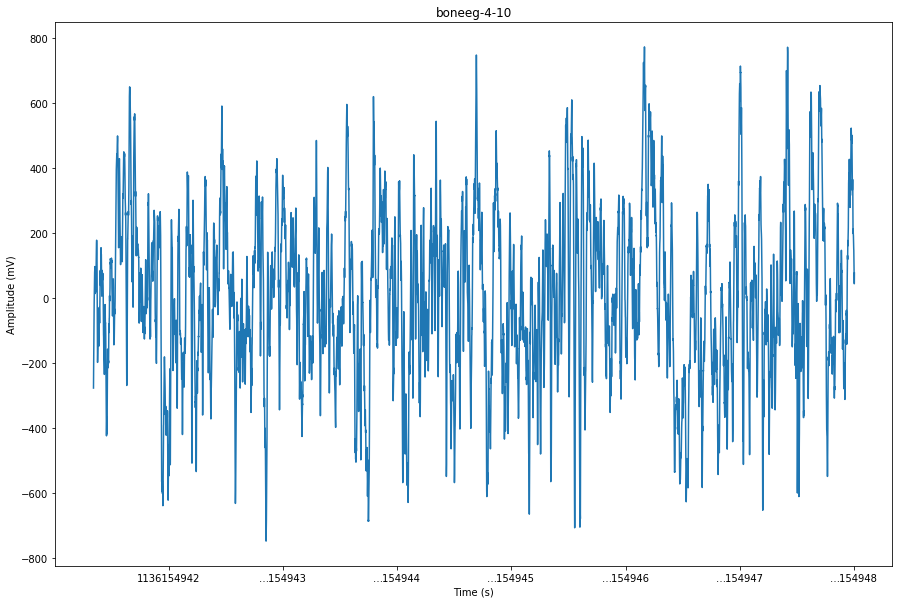

In [30]:
def fmt_sec_from_midnight (x, pos):
    x_posix = mdates.num2epoch(x)
    x_dt = mdates.num2date(x) 
    prev_midnight = x_dt.replace(hour=0, minute=0, second=0, microsecond=0)
    return (x_dt - prev_midnight).total_seconds()
#    return "%0.6f" % mdates.num2epoch(x)

def fmt_truncate_posix (x, pos, oom=6):
#     offset_str = "%de%d + \n" % (x // 10 ** oom, oom)
    ellipsis = "\u2026"
    offset_str = "%d" % (x // 10 ** oom)
    # oom zero-padded digits before decimal point and up to 6 digits past it 
    # (no trailing zeros)
    # NB no way to do this with single format string: %05.11g gives too many digits past 
    #the decimal when integer part is small.
    remainder_str = ("%%0%dd" % oom) % (x % 10 ** oom) + \
                    ("%0.6g" % (x % 1))[1:] # omit leading 0
    if pos == 1: # first visible tick
        print (x)
#         return offset_str + ellipsis + "\n" + ellipsis + remainder_str
        return offset_str + remainder_str
    else:
        return "\u2026" + remainder_str

fig1 = plt.figure(1, figsize=(15,10))
ax1 = fig1.add_subplot(1,1,1)
print(ax1.xaxis.major.formatter)
xtick_locator = mticker.AutoLocator()
xtick_formatter = mticker.FuncFormatter(fmt_truncate_posix)
# xtick_formatter = mdates.AutoDateFormatter(xtick_locator)
# xtick_formatter = mticker.ScalarFormatter(xtick_locator)


for i in [1]: #range(len(list(nwbf_read.get_acquisition('LFP').electrical_series.items()))):
    example_es_name, example_es = list(nwbf_read.get_acquisition('LFP').electrical_series.items())[i]
    nwbf_read.get_acquisition('LFP').electrical_series
    #ts = (example_es.timestamps.value[-1001:-1]*1e9).astype('datetime64[ns]')
    ts = example_es.timestamps.value[-10001:-1] 
    print("plot #%d" % i)
    ax1.plot(ts, example_es.data[0:10000] * 1000)

ax1.set_title(example_es_name)
ax1.set_xlabel('Time (s)')
# ax1.set_xlabel('Time (s; prefix = 113615\u2026)')
ax1.set_ylabel('Amplitude (mV)')
ax1.xaxis.set_major_locator(xtick_locator)
ax1.xaxis.set_major_formatter(xtick_formatter)
print(ax1.xaxis.major.formatter)


# xtick_locator = mdates.AutoDateLocator()


#fig1.autofmt_xdate()

In [37]:
#io.close()